In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import torch

Nors kursime ir apmokysime Transformerio modelį, nereiki jungtis prie GPU - modelis yra sąlyginai mažas.

**Užduotys:**

1. Užbaikite visų transformeriui reikalingų elementų klases. Kiekvienas turi paveldėti `torch.nn.Module` klasę. Nerašykite jokių papildomų/naujų funkcijų, tik pabaikite kas jau buvo pradėta.
   - `PositionalEncoding`
   - `InputEmbeddings`
   - `MultiHeadAttention`
   - `PositionWiseFeedForward`
   - `LayerNorm`
   - `EncoderLayer` (sudarytas iš mažesnių komponentų)
   - `DecoderLayer` (sudarytas iš mažesnių komponentų)
   - `Transformer` (sudarytas iš `EncoderLayer`, `DecoderLayer` ir pagalbinių dalykų)
   - Leidžiama naudotis tik šiomis `torch.nn` sluoksnių funkcijomis: `Parameter`, `Linear`, `Embedding`, `Dropout`, `Module`. Taip pat leidžiamos bet kurios `Numpy` funkcijos.
2. Sugeneruokite dirbtinius duomenis.
   - Įvesties žodyno dydis 3000, išvesties žodyno dydis 2500, sakinio ilgis 100, partijos (*batch*) dydis 64.
   - Nedarykit pilnai atsitiktinių duomenų. Iš pradžių, sugeneruokite atsitiktinius įvesties duomenis, tačiau išvesties duomenys turi būti sugeneruoti iš įvesties: apsukite seką į kitą pusę, bei pakeiskite ~20% žodžių.
   - Įsitikinkite, kad užfiksavote duomenų generavimo sėklą (*random seed*).
3. Sukonstruokite transformerio modelio objektą: įterpinių dydis 128, *Feed Forward* dydis 4 kart didesnis už įterpinius, 6 dėmesio sluoksniai, 4 dėmesio galvutės, *dropout* 20%.
4. Sukurkite Adam optimizatoriaus objektą su `torch.optim.Adam`, bei nuostolių funkciją `torch.nn.CrossEntropyLoss`.
5. Atvaizduokite, kaip atrodo pirma dėmesio matrica pirmame bloke ir paskutiniame bloke, prieš apmokymą ir paskui po apmokymo.
6. Apmokykite transformerį bent 10 epochų. Atvaizduokite nuostolių kitimo kreivę. Apmokykite transformerį dar daugiau epochų. Kokį geriausią rezultatą galite pasiekti?
7. Pabandykite patobulinti modelį. Pažiūrėkite, kaip jo veikimas keičiasi su skirtingu svorių inicializavimu; skirtinga atsitiktine sėkla; mažiau ar daugiau dėmesio sluoksnių; stipresnių ar silpnesnių *dropout* parametrų...

In [2]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d, n_heads):
        super().__init__()
        self.d = d
        self.h = n_heads

        assert d % n_heads == 0, "įterpinių dydis turi dalintis iš dėmesio galvučių kiekio"
        self.d_k = d // n_heads  # vienos galvutės dydis

        # čia naudokite torch.nn.Linear
        self.W_q = torch.nn.Linear(d, d, bias=False)  # užklausos (queries)
        self.W_k = torch.nn.Linear(d, d, bias=False)  # raktai    (keys)
        self.W_v = torch.nn.Linear(d, d, bias=False)  # reikšmės  (values)
        self.W_o = torch.nn.Linear(d, d, bias=False)  # išvestys  (outputs)
        self.attn_scores = None # Add this line to store attention scores

    def attention(self, Q, K, V, mask=None):
        attention_scores = (Q @ K.transpose(-2, -1)) / np.sqrt(self.d_k)   # pagrindinė dėmesio formulė

        # maskavimas - pvz. jeigu reikėjo paddinti sakinius
        if mask is not None:
            very_low_value = -1e9
            attention_scores.masked_fill_(mask == 0, very_low_value)

        attention_scores = torch.softmax(attention_scores, dim=1)  # pritaikyti softmax
        self.attn_scores = attention_scores # Store attention scores
        return attention_scores @ V   # galiausiai panaudoti V marticą

    def split_heads(self, x):
        # paima (batch_size, s, d) matricą ir grąžina (batch_size, h, s, d_k)
        batch_size, seq_len, d = x.size()
        return x.view(batch_size, seq_len, self.h, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # paima (batch_size, h, s, d_k) matricą ir grąžina (batch_size, s, d)
        batch_size, h, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d)

    def forward(self, Q, K, V, mask=None):
        # po Q, K, V gavimo iškart panaudokite split_heads()
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        att_out = self.attention(Q, K, V, mask)

        # papildoma tiesinė transformacija gale
        out = self.W_o(self.combine_heads(att_out))

        return out



class PositionalEncoding(torch.nn.Module):
    def __init__(self, d, seq_len):
        super().__init__()
        self.d = d
        self.s = seq_len

        # paruošiame teisingo dydžio matricą įterpiniams
        pe = torch.zeros(seq_len, d)

        # Gauname (s, 1) pradinių pozicijų matricą (tiesiog skaičių)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)

        # paverčiame skaičius į sin/cos rezultatus, n=10000
        div_term = torch.exp(torch.arange(0, d, 2).float() * (-np.log(10000.0) / d))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Pridedame matmenį partijoms (batches)
        pe = pe.unsqueeze(0)
        # PE nėra modelio parametras, bet turi būti pernešamas kartu su modeliu jei reikes
        self.register_buffer('pe', pe)

    def forward(self, x):
        # requires_grad_(False) reiškia kad PE nebus keičiamas mokymosi metu
        return x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)


class InputEmbeddings(torch.nn.Module):
    def __init__(self, d, vocab_size):
        super().__init__()
        self.d = d
        self.vocab_size = vocab_size
        self.embedding = torch.nn.Embedding(vocab_size, d)  # torch.nn.Embedding

    def forward(self, x):
        # normalizavimui dauginama iš d kvadratinės šaknies
        return self.embedding(x) * np.sqrt(self.d)


class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, d, d_ff):
        super().__init__()
        # pirmas, antras ir vėl pirmas matmens dydis
        self.linear1 = torch.nn.Linear(d, d_ff)  # torch.nn.Linear
        self.linear2 = torch.nn.Linear(d_ff, d)  # torch.nn.Linear
        self.relu = torch.nn.ReLU() # Instantiate ReLU here

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))  # tarp sluoksnių dar panaudokite torch.relu


class LayerNorm(torch.nn.Module):
    def __init__(self, n_features, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
        self.a = torch.nn.Parameter(torch.ones(n_features))  # torch.nn.Parameter, pradėkite nuo visų vienetų
        self.b = torch.nn.Parameter(torch.zeros(n_features))  # torch.nn.Parameter, pradėkite nuo visų nulių

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return self.a * (x - mean) / (std + self.epsilon) + self.b  # normalizavimo sluoksnis


class EncoderLayer(torch.nn.Module):
    def __init__(self, d, h, d_ff, dropout):
        super().__init__()
        # surinkite enkoderį pagal standartinę schemą
        # su dėmesiu, FeedForward, dviejų normalizavimo sluoksnių
        # galia pridėkite torch.nn.Dropout
        self.self_att = MultiHeadAttention(d, h)
        self.norm1 = LayerNorm(d)
        self.norm2 = LayerNorm(d)
        self.feed_forward = PositionWiseFeedForward(d, d_ff)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        att_output = self.self_att(x, x, x, mask)
        # pirmas sluoksnio normalizavimas po dėmesio blokų
        x = self.norm1(x + self.dropout(att_output))

        ff_output = self.feed_forward(x)
        # antras sluoksnio normalizavimas
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(torch.nn.Module):
    def __init__(self, d, h, d_ff, dropout):
        super().__init__()
        # surinkite dekoderį pagal standartinę schemą
        self.self_att = MultiHeadAttention(d, h)
        self.cross_att = MultiHeadAttention(d, h)
        self.feed_forward = PositionWiseFeedForward(d, d_ff)
        # po kiekvieno iš šių sluoksnių dar turės eiti atskiras normalizavimo sluoksnis
        # galia pridėkite torch.nn.Dropout
        self.norm1 = LayerNorm(d)
        self.norm2 = LayerNorm(d)
        self.norm3 = LayerNorm(d)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, encoder_out, src_mask, tgt_mask):
        att_output = self.self_att(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(att_output))  # norm
        att_output = self.cross_att(x, encoder_out, encoder_out, src_mask)
        x = self.norm2(x + self.dropout(att_output))  # norm
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))  # norm
        return x



class Transformer(torch.nn.Module):
    def __init__(self, d, n_heads, d_ff, n_blocks, src_vocab_size, tgt_vocab_size, dropout=0.1):
        super().__init__()
        # galiausiai surinkite pilną transformerį

        # pradėkite nuo torch.nn.Embedding sluoksnių, enkoderiui ir dekoderiui
        self.encoder_embedding = InputEmbeddings(d, src_vocab_size)
        self.decoder_embedding = InputEmbeddings(d, tgt_vocab_size)

        self.positional_encoding = PositionalEncoding(d, seq_len=500)

        # Transformeris turi priimti n_blocks parametrą. Tai yra enkoderio ir dekoderio pakartojimų (blokų) kiekis.
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d, n_heads, d_ff, dropout) for _ in range(n_blocks)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(d, n_heads, d_ff, dropout) for _ in range(n_blocks)])

        # paskutinis modelio paprasčiausias sluoksnis
        self.fc = torch.nn.Linear(d, tgt_vocab_size)

        # bus reikalingas papildomas dropout'as
        self.dropout = torch.nn.Dropout(dropout)

    # maskavimo generavimas
    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_len = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_len, seq_len), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        # gauname maskavimą
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # gauname pozicijos įterpinius, jas praleiskite pro Dropout'ą
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # panaudojame enkoderių sluoksnius
        encoder_out = src_embedded
        for enc_layer in self.encoder_layers:
            encoder_out = enc_layer(encoder_out, src_mask)

        # panaudojame dekoderio sluoksnius
        decoder_out = tgt_embedded
        for dec_layer in self.decoder_layers:
            decoder_out = dec_layer(decoder_out, encoder_out, src_mask, tgt_mask)

        # praleidžiame pro paskutinį paprastą sluoksnį
        output = self.fc(decoder_out)
        return output

In [3]:
input_vocab_size = 3000
target_vocab_size = 2500
seq_len = 100
batch_size = 64

d_model = 128
d_ff = d_model * 4
n_heads = 4
n_blocks = 6
dropout = 0.2

transformer = Transformer(
    d=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    n_blocks=n_blocks,
    src_vocab_size=input_vocab_size,
    tgt_vocab_size=target_vocab_size,
    dropout=dropout
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# duomenų generavimas
src_data = torch.randint(1, input_vocab_size, (batch_size, seq_len))
tgt_data = torch.flip(src_data, dims=[1])
# pakeičiame 20% žodžių atsitiktiniais
noise_mask = torch.rand(tgt_data.shape) < 0.2
random_noise = torch.randint(1, target_vocab_size, tgt_data.shape)
tgt_data = torch.where(noise_mask, random_noise, tgt_data)

# Užtikriname, kad tgt_data reikšmės neviršytų target_vocab_size
tgt_data = torch.clamp(tgt_data, max=target_vocab_size-1)

In [12]:
tgt_data.shape

torch.Size([64, 100])

In [13]:
src_data.shape

torch.Size([64, 100])

In [4]:
# naudosime kryžminės entropijos funkciją iš torch
loss_func = torch.nn.CrossEntropyLoss(ignore_index=0)
# naudosime Adam optimizatorių
optimizer = torch.optim.Adam(transformer.parameters(),
                             lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [5]:
# perjungiame transformerį į apmokymą
transformer.train()

Transformer(
  (encoder_embedding): InputEmbeddings(
    (embedding): Embedding(3000, 128)
  )
  (decoder_embedding): InputEmbeddings(
    (embedding): Embedding(2500, 128)
  )
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_att): MultiHeadAttention(
        (W_q): Linear(in_features=128, out_features=128, bias=False)
        (W_k): Linear(in_features=128, out_features=128, bias=False)
        (W_v): Linear(in_features=128, out_features=128, bias=False)
        (W_o): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (feed_forward): PositionWiseFeedForward(
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (relu): ReLU()
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderLayer(


In [6]:
# galime apskaičiuoti mūsų transformerio dydį
param_size = 0
for param in transformer.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in transformer.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print(f'model size: {size_all_mb:.3f}MB')

model size: 14.719MB


In [7]:
def plot_attention(model, src, tgt, title="Dėmesio matrica"):
    model.eval()
    with torch.no_grad():
        # Paleidžiame forward pass tik vienam pavyzdžiui
        _ = model(src[:1], tgt[:1, :-1])

        # Paimame pirmo enkoderio sluoksnio dėmesio svorius
        # EncoderLayer -> MultiHeadAttention (self_att) -> attn_scores
        first_layer_attn = model.encoder_layers[0].self_att.attn_scores[0, 0].cpu().numpy() # [Head 0]

        # Paimame paskutinio enkoderio sluoksnio dėmesio svorius
        last_layer_attn = model.encoder_layers[-1].self_att.attn_scores[0, 0].cpu().numpy() # [Head 0]

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        im1 = axes[0].imshow(first_layer_attn, cmap='viridis', aspect='auto')
        axes[0].set_title(f"Pirmas blokas (Head 0)")
        axes[0].set_xlabel("Raktas (Key)")
        axes[0].set_ylabel("Užklausa (Query)")

        im2 = axes[1].imshow(last_layer_attn, cmap='viridis', aspect='auto')
        axes[1].set_title(f"Paskutinis blokas (Head 0)")
        axes[1].set_xlabel("Raktas (Key)")

        fig.suptitle(title)
        plt.colorbar(im1, ax=axes[0])
        plt.colorbar(im2, ax=axes[1])
        plt.show()

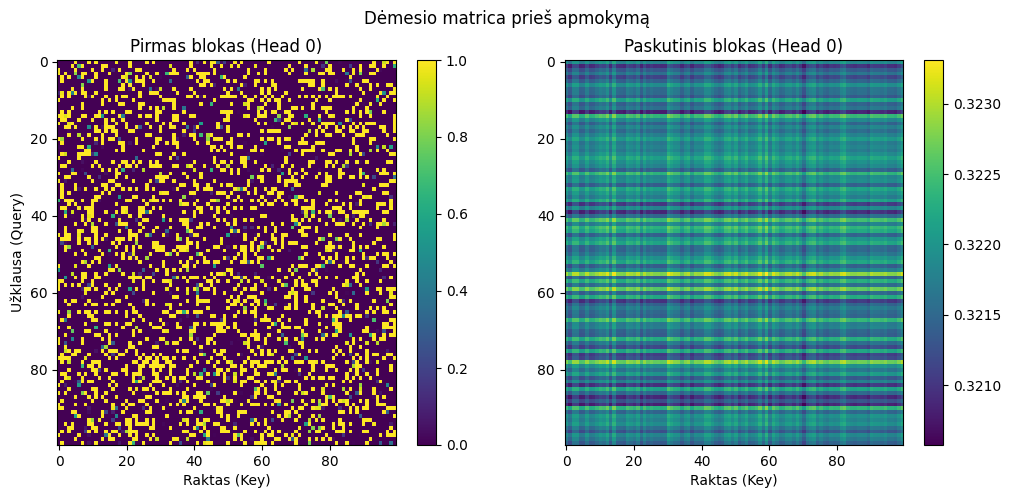

In [8]:
plot_attention(transformer, src_data, tgt_data, title="Dėmesio matrica prieš apmokymą")

 10%|█         | 1/10 [00:06<00:58,  6.47s/it]

Epoch: 1 | Loss: 8.068352699279785


 20%|██        | 2/10 [00:11<00:46,  5.75s/it]

Epoch: 2 | Loss: 7.899106025695801


 30%|███       | 3/10 [00:18<00:42,  6.01s/it]

Epoch: 3 | Loss: 7.781187057495117


 40%|████      | 4/10 [00:23<00:33,  5.65s/it]

Epoch: 4 | Loss: 7.6896891593933105


 50%|█████     | 5/10 [00:29<00:28,  5.80s/it]

Epoch: 5 | Loss: 7.608918190002441


 60%|██████    | 6/10 [00:34<00:22,  5.59s/it]

Epoch: 6 | Loss: 7.535855770111084


 70%|███████   | 7/10 [00:39<00:16,  5.57s/it]

Epoch: 7 | Loss: 7.474401473999023


 80%|████████  | 8/10 [00:45<00:11,  5.57s/it]

Epoch: 8 | Loss: 7.425680637359619


 90%|█████████ | 9/10 [00:50<00:05,  5.42s/it]

Epoch: 9 | Loss: 7.386658191680908


100%|██████████| 10/10 [00:56<00:00,  5.66s/it]

Epoch: 10 | Loss: 7.355252265930176


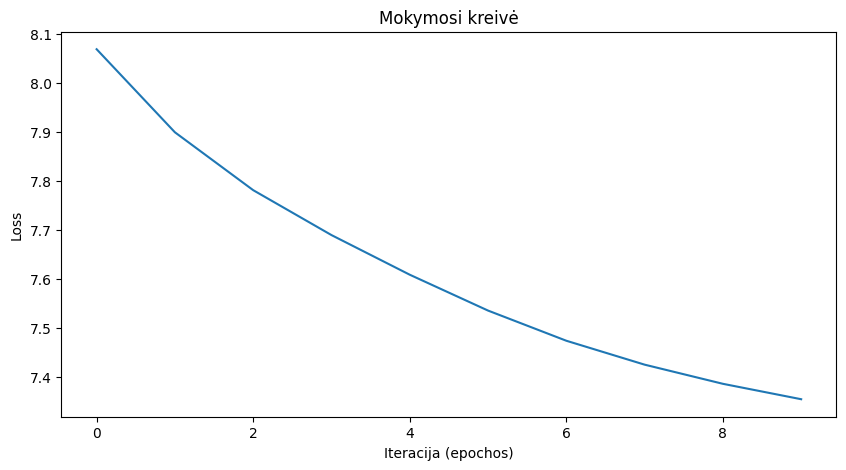

In [9]:
# liko paleisti apmokymą
losses = []
n_epochs = 10

for epoch in trange(n_epochs):
    # ištriname senus gradientus
    optimizer.zero_grad()
    # gauname naują išvestį iš transformerio
    output = transformer(src_data, tgt_data[:, :-1])
    # paskaičiuojame nuostolių dydį
    loss = loss_func(output.contiguous().view(-1, target_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    # skaičiuojame gradientus
    loss.backward()
    # optimizatorius daro žingsnį: atnaujina transformerio svorius
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch: {epoch+1} | Loss: {loss.item()}")

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Mokymosi kreivė")
plt.xlabel("Iteracija (epochos)")
plt.ylabel("Loss")
plt.show()

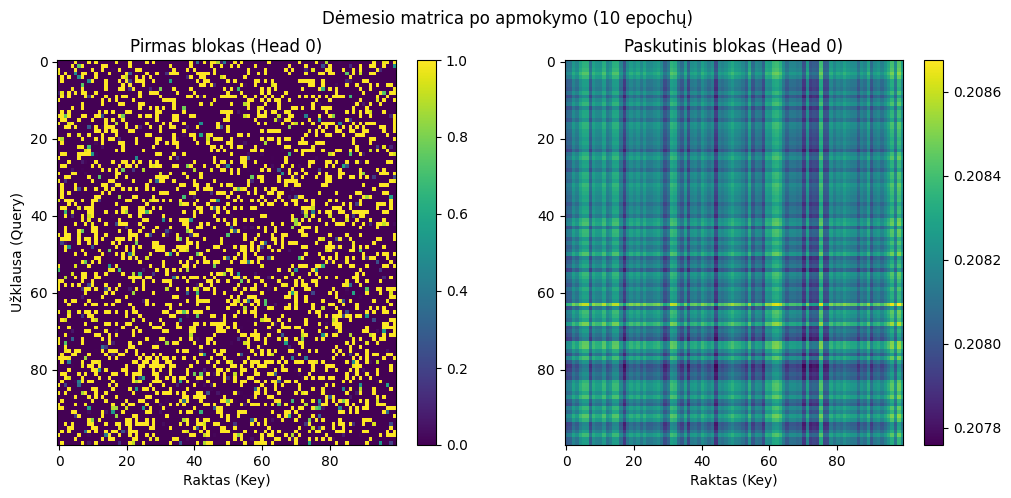

In [10]:
plot_attention(transformer, src_data, tgt_data, title="Dėmesio matrica po apmokymo (10 epochų)")

Papildomas apmokymas: 100%|██████████| 40/40 [03:39<00:00,  5.49s/it]


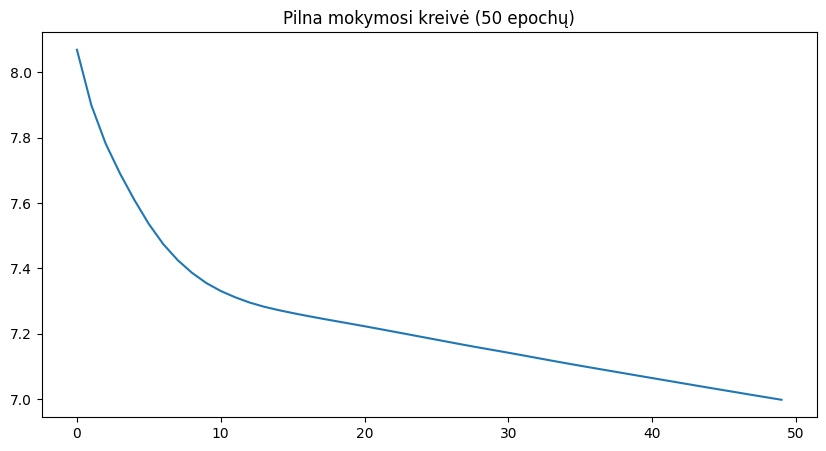

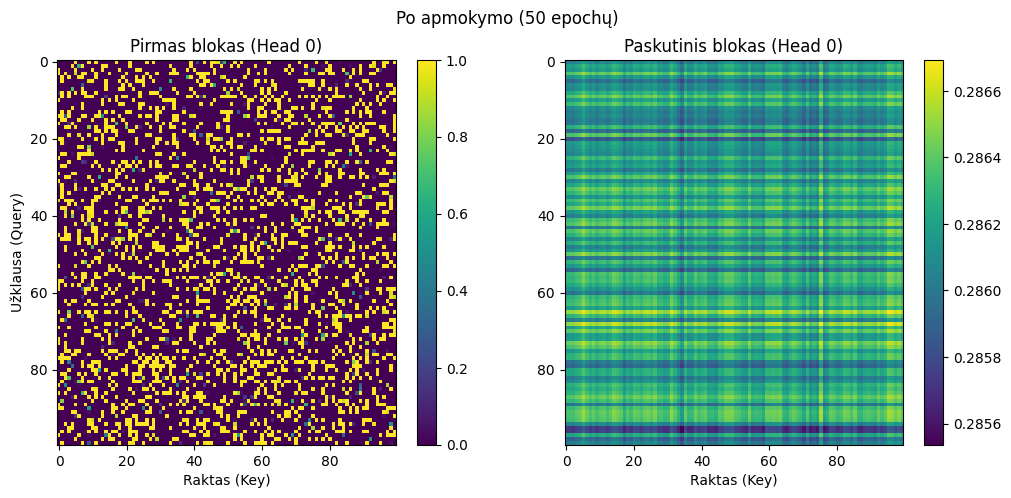

In [11]:
more_epochs = 40
for epoch in trange(more_epochs, desc="Papildomas apmokymas"):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = loss_func(output.reshape(-1, target_vocab_size), tgt_data[:, 1:].reshape(-1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Pilna mokymosi kreivė (50 epochų)")
plt.show()

plot_attention(transformer, src_data, tgt_data, title="Po apmokymo (50 epochų)")